# ===========================================================
# Solve the estimation problem with neural network tower model on the supervised dataset from the Jeopardy-like logs
# ===========================================================

Goals:
1. Split the data into test and train
2. Formulate the neural network based model
3. Compute train and test error

#### Last update: 09 Dec 2019

# Imports

In [48]:
from __future__ import division, print_function, absolute_import, unicode_literals

import scipy as sp
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import sys
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Conv1D, LSTM, MaxPooling1D, GlobalAveragePooling1D
from tensorflow.keras import regularizers

sys.path.insert(0, '../src/')
%matplotlib inline

import utils
from mytimer import Timer

# Parameters

In [49]:
data_fpath = '/home/omid/Datasets/Jeopardy/supervised_data.pk'
# data_fpath = '/home/omid/Datasets/Jeopardy/supervised_data_roberta.pk'
test_fraction = 0.2
runs = 30

# Helper functions

In [82]:
def compute_matrix_err(true_matrix: np.matrix, pred_matrix: np.matrix, type_str: str = 'frob_norm') -> float:
    if type_str == 'frob_norm':
        frob_norm_of_difference = np.linalg.norm(true_matrix - pred_matrix)
        err = frob_norm_of_difference / np.linalg.norm(true_matrix)
        return err
    elif type_str == 'corr':
#         (r, p) = sp.stats.spearmanr(np.array(true_matrix.flatten())[0], np.array(pred_matrix.flatten())[0])
        (r, p) = sp.stats.pearsonr(np.array(true_matrix.flatten())[0], np.array(pred_matrix.flatten())[0])
        if p > 0.05:
            r = 0
        return r
    elif type_str == 'cosine':
        err = sp.spatial.distance.cosine(
            np.array(true_matrix.flatten())[0], np.array(pred_matrix.flatten())[0])
        return err
    else:
        raise ValueError('Wrong type_str was given.')

In [83]:
def get_eigvec_of_laplacian(A: np.matrix) -> np.matrix:
#     D = np.diag(np.array(np.sum(A, axis=0))[0])
#     L = D - A
#     return np.matrix(np.linalg.eig(L)[1])
    n, m = A.shape
    diags = A.sum(axis=1).flatten()
    D = sp.sparse.spdiags(diags, [0], m, n, format='csr')
    L = D - A
    with sp.errstate(divide='ignore'):
        diags_sqrt = 1.0/sp.sqrt(diags)
    diags_sqrt[sp.isinf(diags_sqrt)] = 0
    DH = sp.sparse.spdiags(diags_sqrt, [0], m, n, format='csr')
    DH = DH.todense()
    normalized_L = DH.dot(L.dot(DH))
    return normalized_L

In [52]:
def my_init(shape, dtype=None):
    return np.ones(shape) * 0.25

# Loading the data

In [53]:
data = utils.load_it(data_fpath)
print(len(data['X']))

309


In [54]:
mats = []
for i in range(len(data['y'])):
    mats.append(data['y'][i]['influence_matrix'])

In [55]:
np.mean(mats, axis=0)

array([[0.25906952, 0.24905243, 0.25700584, 0.23487221],
       [0.22331056, 0.32544628, 0.22024244, 0.23100072],
       [0.21267519, 0.25090613, 0.31034735, 0.22607133],
       [0.25209233, 0.23995288, 0.2409886 , 0.26696619]])

In [56]:
np.std(mats, axis=0)

array([[0.12121653, 0.08048964, 0.09161217, 0.07770627],
       [0.09630495, 0.17456327, 0.08476215, 0.10845003],
       [0.09183082, 0.12230915, 0.17582025, 0.09195666],
       [0.09730267, 0.06870681, 0.06307793, 0.09241992]])

# Formulating the tower model

## Only content embeddings

In [76]:
with Timer():

    model_errs = []
    random_errs = []
    uniform_errs = []

    for run in range(runs):
        print('Run', run, '...')
        X_train, X_test, y_train, y_test = train_test_split(
            data['X'], data['y'], test_size=test_fraction)
        
#         mats = []
#         for i in range(len(y_train)):
#             mats.append(y_train[i]['influence_matrix'])
#         average_matrix = np.mean(mats, axis=0)

        flatten_X_train = []
        flatten_y_train = []
        for i in range(len(X_train)):
            features = X_train[i]
            label = y_train[i]['influence_matrix']            
#             flatten_X_train.append(np.array(features['reply_duration'].flatten())[0])
            flatten_X_train.append(features['content_embedding_matrix'].flatten())
            flatten_y_train.append(np.array(label.flatten())[0])
        flatten_X_train = np.array(flatten_X_train)
        flatten_y_train = np.array(flatten_y_train)

        flatten_X_test = []
        flatten_y_test = []
        for i in range(len(X_test)):
            features = X_test[i]
            label = y_test[i]['influence_matrix']
#             flatten_X_test.append(np.array(features['reply_duration'].flatten())[0])
            flatten_X_test.append(features['content_embedding_matrix'].flatten())
            flatten_y_test.append(np.array(label.flatten())[0])
        flatten_X_test = np.array(flatten_X_test)
        flatten_y_test = np.array(flatten_y_test)

        model = Sequential([
            Dense(32, kernel_initializer='he_normal', activation='relu', input_shape=(3072,)),
            Dropout(0.5),
            Dense(64, kernel_initializer='he_normal', activation='relu'),
            Dropout(0.5),
            Dense(32, kernel_initializer='he_normal', activation='relu'),
            Dropout(0.5),
#             Dense(16, kernel_initializer='he_normal', activation='softmax')])
            Dense(16, kernel_initializer=my_init, activation='softmax')])
        model.compile(optimizer='adam',
                      loss='binary_crossentropy',
                      metrics=['accuracy'])
#         model = Sequential([
#             Dense(
#                 units=32,
#                 kernel_initializer='he_normal',
#                 activation='relu',
#                 input_shape=(3072,),
#                 kernel_regularizer=regularizers.l1(lambda1)),
#             Dropout(0.5),
#             Dense(
#                 units=64,
#                 kernel_initializer='he_normal',
#                 activation='relu',
#                 kernel_regularizer=regularizers.l1(lambda1)),
#             Dropout(0.5),
#             Dense(
#                 units=32,
#                 kernel_initializer='he_normal',
#                 activation='relu',
#                 kernel_regularizer=regularizers.l1(lambda1)),
#             Dropout(0.5),
#             Dense(
#                 units=16,
#                 kernel_initializer='he_normal',
#                 activation='softmax',
#                 kernel_regularizer=regularizers.l1(lambda1))
#         ])
#         model.compile(optimizer='adam',
#                       loss='binary_crossentropy',
#                       metrics=['accuracy'])

        model.fit(flatten_X_train, flatten_y_train, epochs=10, batch_size=32)

        predicted = model.predict(flatten_X_test)

        model_err = 0
        uniform_err = 0
        random_err = 0
        for i in range(len(y_test)):
            real_influence_matrix = y_test[i]['influence_matrix']

            # Random model prediction:
            pred_random_influence_matrix = np.matrix(utils.make_matrix_row_stochastic(
                np.random.rand(4, 4)))
            random_err += compute_matrix_err(
                real_influence_matrix, pred_random_influence_matrix)

            # Uniform prediction:
            pred_uniform_influence_matrix = np.matrix(np.ones((4, 4)) * 0.25)
            uniform_err += compute_matrix_err(
                real_influence_matrix, pred_uniform_influence_matrix)

            # Model's prediction:
            predicted_influence_matrix = predicted[i]
            predicted_influence_matrix = utils.make_matrix_row_stochastic(
                np.matrix(np.reshape(predicted_influence_matrix, (4, 4))))
            model_err += compute_matrix_err(
                real_influence_matrix, predicted_influence_matrix)

        model_err /= len(y_test)
        uniform_err /= len(y_test)
        random_err /= len(y_test)

        model_errs.append(model_err)
        random_errs.append(random_err)
        uniform_errs.append(uniform_err)

Run 0 ...
Train on 269 samples
Epoch 1/10
269/269 [==============================] - 1s 2ms/sample - loss: 0.7396 - accuracy: 0.0188
Epoch 2/10
269/269 [==============================] - 0s 106us/sample - loss: 0.7387 - accuracy: 0.0188
Epoch 3/10
269/269 [==============================] - 0s 107us/sample - loss: 0.7385 - accuracy: 0.0188
Epoch 4/10
269/269 [==============================] - 0s 97us/sample - loss: 0.7382 - accuracy: 0.0188
Epoch 5/10
269/269 [==============================] - 0s 91us/sample - loss: 0.7379 - accuracy: 0.0188
Epoch 6/10
269/269 [==============================] - 0s 79us/sample - loss: 0.7377 - accuracy: 0.0188
Epoch 7/10
269/269 [==============================] - 0s 81us/sample - loss: 0.7372 - accuracy: 0.0188
Epoch 8/10
269/269 [==============================] - 0s 78us/sample - loss: 0.7373 - accuracy: 0.0188
Epoch 9/10
269/269 [==============================] - 0s 78us/sample - loss: 0.7364 - accuracy: 0.0188
Epoch 10/10
269/269 [====================

269/269 [==============================] - 0s 67us/sample - loss: 0.7372 - accuracy: 0.0179
Epoch 9/10
269/269 [==============================] - 0s 67us/sample - loss: 0.7368 - accuracy: 0.0179
Epoch 10/10
269/269 [==============================] - 0s 70us/sample - loss: 0.7370 - accuracy: 0.0179
Run 8 ...
Train on 269 samples
Epoch 1/10
269/269 [==============================] - 1s 2ms/sample - loss: 0.7389 - accuracy: 0.0167
Epoch 2/10
269/269 [==============================] - 0s 95us/sample - loss: 0.7381 - accuracy: 0.0167
Epoch 3/10
269/269 [==============================] - 0s 96us/sample - loss: 0.7379 - accuracy: 0.0167
Epoch 4/10
269/269 [==============================] - 0s 69us/sample - loss: 0.7373 - accuracy: 0.0167
Epoch 5/10
269/269 [==============================] - 0s 74us/sample - loss: 0.7372 - accuracy: 0.0167
Epoch 6/10
269/269 [==============================] - 0s 87us/sample - loss: 0.7369 - accuracy: 0.0167
Epoch 7/10
269/269 [==============================] -

269/269 [==============================] - 0s 96us/sample - loss: 0.7365 - accuracy: 0.0193
Epoch 6/10
269/269 [==============================] - 0s 79us/sample - loss: 0.7362 - accuracy: 0.0193
Epoch 7/10
269/269 [==============================] - 0s 76us/sample - loss: 0.7358 - accuracy: 0.0193
Epoch 8/10
269/269 [==============================] - 0s 74us/sample - loss: 0.7358 - accuracy: 0.0193
Epoch 9/10
269/269 [==============================] - 0s 66us/sample - loss: 0.7356 - accuracy: 0.0193
Epoch 10/10
269/269 [==============================] - 0s 69us/sample - loss: 0.7361 - accuracy: 0.0193
Run 16 ...
Train on 269 samples
Epoch 1/10
269/269 [==============================] - 1s 2ms/sample - loss: 0.7391 - accuracy: 0.0167
Epoch 2/10
269/269 [==============================] - 0s 81us/sample - loss: 0.7385 - accuracy: 0.0167
Epoch 3/10
269/269 [==============================] - 0s 83us/sample - loss: 0.7384 - accuracy: 0.0167
Epoch 4/10
269/269 [==============================] 

random: 0.6358637687891749 +- 0.017407726721425588
uniform: 0.3522141490130312 +- 0.018461737356623154
model: 0.34663943089383537 +- 0.016315834977931095


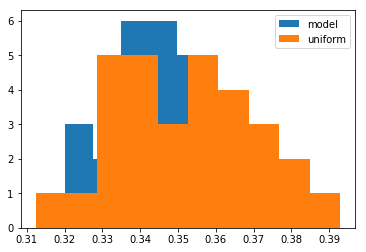

In [77]:
plt.hist(model_errs)
# plt.hist(random_errs)
plt.hist(uniform_errs)
# plt.legend(['model', 'random', 'uniform']);
plt.legend(['model', 'uniform'])

print('random: {} +- {}'.format(np.mean(random_errs), np.std(random_errs)))
print('uniform: {} +- {}'.format(np.mean(uniform_errs), np.std(uniform_errs)))
print('model: {} +- {}'.format(np.mean(model_errs), np.std(model_errs)));

## Only networks

In [15]:
all_networks = True
one_type_network = 'reply_duration'   # 'emotion_dominance'
input_dim = 80
lambda1 = 1

In [16]:
with Timer():

    model_errs = []
    random_errs = []
    uniform_errs = []
    for run in range(runs):
        print('Run', run, '...')
        X_train, X_test, y_train, y_test = train_test_split(
            data['X'], data['y'], test_size=test_fraction)

        flatten_X_train = []
        flatten_y_train = []
        for i in range(len(X_train)):
            features = X_train[i]
            label = y_train[i]['influence_matrix']
            if all_networks:
                flatten_X_train.append(np.hstack(
                    [np.array(features['reply_duration'].flatten())[0],
                     np.array(features['sentiment'].flatten())[0],
                     np.array(features['emotion_arousal'].flatten())[0],
                     np.array(features['emotion_dominance'].flatten())[0],
                     np.array(features['emotion_valence'].flatten())[0]]))
            else:
                flatten_X_train.append(np.array(features[one_type_network].flatten())[0])
            flatten_y_train.append(np.array(label.flatten())[0])
        flatten_X_train = np.array(flatten_X_train)
        flatten_y_train = np.array(flatten_y_train)

        flatten_X_test = []
        flatten_y_test = []
        for i in range(len(X_test)):
            features = X_test[i]
            label = y_test[i]['influence_matrix']
            if all_networks:
                flatten_X_test.append(np.hstack(
                    [np.array(features['reply_duration'].flatten())[0],
                     np.array(features['sentiment'].flatten())[0],
                     np.array(features['emotion_arousal'].flatten())[0],
                     np.array(features['emotion_dominance'].flatten())[0],
                     np.array(features['emotion_valence'].flatten())[0]]))
            else:
                flatten_X_test.append(np.array(features[one_type_network].flatten())[0])
            flatten_y_test.append(np.array(label.flatten())[0])
        flatten_X_test = np.array(flatten_X_test)
        flatten_y_test = np.array(flatten_y_test)
        
        model = Sequential([
            Dense(
                units=32,
                kernel_initializer='he_normal',
                activation='relu',
                input_shape=(input_dim,),
                kernel_regularizer=regularizers.l1(lambda1),
                activity_regularizer=regularizers.l1(lambda1)),
            Dropout(0.5),
            Dense(
                units=64,
                kernel_initializer='he_normal',
                activation='relu',
                kernel_regularizer=regularizers.l1(lambda1),
                activity_regularizer=regularizers.l1(lambda1)),
            Dropout(0.5),
            Dense(
                units=32,
                kernel_initializer='he_normal',
                activation='relu',
                kernel_regularizer=regularizers.l1(lambda1),
                activity_regularizer=regularizers.l1(lambda1)),
            Dropout(0.5),
            Dense(
                units=16,
                kernel_initializer='he_normal',
                activation='softmax',
                kernel_regularizer=regularizers.l1(lambda1),
                activity_regularizer=regularizers.l1(lambda1))
        ])
        model.compile(optimizer='adam',
                      loss='binary_crossentropy',
                      metrics=['accuracy'])

        model.fit(flatten_X_train, flatten_y_train, epochs=10, batch_size=32)
        predicted = model.predict(flatten_X_test)

        model_err = 0
        uniform_err = 0
        random_err = 0
        for i in range(len(y_test)):
            real_influence_matrix = y_test[i]['influence_matrix']

            # Random model prediction:
            pred_random_influence_matrix = np.matrix(utils.make_matrix_row_stochastic(
                np.random.rand(4, 4)))
            random_err += compute_matrix_err(
                real_influence_matrix, pred_random_influence_matrix)

            # Uniform prediction:
            pred_uniform_influence_matrix = np.matrix(np.ones((4, 4)) * 0.25)
            uniform_err += compute_matrix_err(
                real_influence_matrix, pred_uniform_influence_matrix)

            # Model's prediction:
            predicted_influence_matrix = predicted[i]
            predicted_influence_matrix = utils.make_matrix_row_stochastic(
                np.matrix(np.reshape(predicted_influence_matrix, (4, 4))))
            model_err += compute_matrix_err(
                real_influence_matrix, predicted_influence_matrix)

        model_err /= len(y_test)
        uniform_err /= len(y_test)
        random_err /= len(y_test)

        model_errs.append(model_err)
        random_errs.append(random_err)
        uniform_errs.append(uniform_err)

Run 0 ...
Train on 269 samples
Epoch 1/10
269/269 [==============================] - 1s 3ms/sample - loss: 1129.2028 - accuracy: 0.0181
Epoch 2/10
269/269 [==============================] - 0s 110us/sample - loss: 1064.8313 - accuracy: 0.0181
Epoch 3/10
269/269 [==============================] - 0s 91us/sample - loss: 1003.3088 - accuracy: 0.0181
Epoch 4/10
269/269 [==============================] - 0s 71us/sample - loss: 944.0386 - accuracy: 0.0181
Epoch 5/10
269/269 [==============================] - 0s 74us/sample - loss: 888.0018 - accuracy: 0.0181
Epoch 6/10
269/269 [==============================] - 0s 76us/sample - loss: 834.2492 - accuracy: 0.0181
Epoch 7/10
269/269 [==============================] - 0s 75us/sample - loss: 782.8130 - accuracy: 0.0181
Epoch 8/10
269/269 [==============================] - 0s 65us/sample - loss: 733.7862 - accuracy: 0.0181
Epoch 9/10
269/269 [==============================] - 0s 69us/sample - loss: 686.8196 - accuracy: 0.0181
Epoch 10/10
269/269 [

269/269 [==============================] - 1s 3ms/sample - loss: 1135.1535 - accuracy: 0.0181
Epoch 2/10
269/269 [==============================] - 0s 95us/sample - loss: 1071.0275 - accuracy: 0.0181
Epoch 3/10
269/269 [==============================] - 0s 88us/sample - loss: 1008.8973 - accuracy: 0.0181
Epoch 4/10
269/269 [==============================] - 0s 79us/sample - loss: 949.9622 - accuracy: 0.0181
Epoch 5/10
269/269 [==============================] - 0s 68us/sample - loss: 892.7380 - accuracy: 0.0181
Epoch 6/10
269/269 [==============================] - 0s 73us/sample - loss: 838.4916 - accuracy: 0.0181
Epoch 7/10
269/269 [==============================] - 0s 65us/sample - loss: 786.4447 - accuracy: 0.0181
Epoch 8/10
269/269 [==============================] - 0s 65us/sample - loss: 736.9422 - accuracy: 0.0181
Epoch 9/10
269/269 [==============================] - 0s 62us/sample - loss: 689.7770 - accuracy: 0.0181
Epoch 10/10
269/269 [==============================] - 0s 65us/s

random: 0.6310301214868926 +- 0.01399059267030896
uniform: 0.34745737869634064 +- 0.017530337002096035
model: 0.34513695020571783 +- 0.016975889090539077


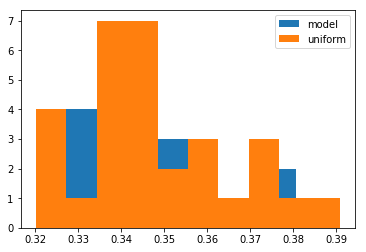

In [17]:
plt.hist(model_errs)
# plt.hist(random_errs)
plt.hist(uniform_errs)
# plt.legend(['model', 'random', 'uniform']);
plt.legend(['model', 'uniform'])

print('random: {} +- {}'.format(np.mean(random_errs), np.std(random_errs)))
print('uniform: {} +- {}'.format(np.mean(uniform_errs), np.std(uniform_errs)))
print('model: {} +- {}'.format(np.mean(model_errs), np.std(model_errs)));

# with Convolutional layers

In [84]:
all_networks = All
one_type_network = 'reply_duration'   # 'emotion_dominance'
input_dim = 16
lambda1 = 1

In [85]:
with Timer():
    model_errs = []
    random_errs = []
    uniform_errs = []
    for run in range(runs):
        print('Run', run, '...')
        X_train, X_test, y_train, y_test = train_test_split(
            data['X'], data['y'], test_size=test_fraction)

        flatten_X_train = []
        flatten_y_train = []
        for i in range(len(X_train)):
            features = X_train[i]
            label = y_train[i]['influence_matrix']
            if all_networks:
                flatten_X_train.append(np.hstack(
                    [np.array(features['reply_duration'].flatten())[0],
                     np.array(features['sentiment'].flatten())[0],
                     np.array(features['emotion_arousal'].flatten())[0],
                     np.array(features['emotion_dominance'].flatten())[0],
                     np.array(features['emotion_valence'].flatten())[0]]))
            else:
                flatten_X_train.append(
                    np.array(get_eigvec_of_laplacian(features[one_type_network]).flatten())[0])
            flatten_y_train.append(np.array(label.flatten())[0])
        flatten_X_train = np.array(flatten_X_train)
        flatten_y_train = np.array(flatten_y_train)

        flatten_X_test = []
        flatten_y_test = []
        for i in range(len(X_test)):
            features = X_test[i]
            label = y_test[i]['influence_matrix']
            if all_networks:
                flatten_X_test.append(np.hstack(
                    [np.array(features['reply_duration'].flatten())[0],
                     np.array(features['sentiment'].flatten())[0],
                     np.array(features['emotion_arousal'].flatten())[0],
                     np.array(features['emotion_dominance'].flatten())[0],
                     np.array(features['emotion_valence'].flatten())[0]]))
            else:
                flatten_X_test.append(
                    np.array(get_eigvec_of_laplacian(features[one_type_network]).flatten())[0])
            flatten_y_test.append(np.array(label.flatten())[0])
        flatten_X_test = np.array(flatten_X_test)
        flatten_y_test = np.array(flatten_y_test)
        
        model = Sequential([
            Conv1D(
                32,
                2,
                kernel_initializer='he_normal',
                activation='relu',
                input_shape=(input_dim, 1),
                kernel_regularizer=regularizers.l1(lambda1),
                activity_regularizer=regularizers.l1(lambda1)),
            Conv1D(
                32,
                2,
                kernel_initializer='he_normal',
                activation='relu',
                kernel_regularizer=regularizers.l1(lambda1),
                activity_regularizer=regularizers.l1(lambda1)),
            MaxPooling1D(2),
            Conv1D(
                64,
                2,
                kernel_initializer='he_normal',
                activation='relu',
                kernel_regularizer=regularizers.l1(lambda1),
                activity_regularizer=regularizers.l1(lambda1)),
            Conv1D(
                64,
                2,
                kernel_initializer='he_normal',
                activation='relu',
                kernel_regularizer=regularizers.l1(lambda1),
                activity_regularizer=regularizers.l1(lambda1)),
            GlobalAveragePooling1D(),
            Dropout(0.5),
            Dense(
                units=16,
                kernel_initializer='he_normal',
                activation='softmax',
                kernel_regularizer=regularizers.l1(lambda1),
                activity_regularizer=regularizers.l1(lambda1))
        ])
        model.compile(optimizer='adam',
                      loss='binary_crossentropy',
                      metrics=['accuracy'])

        model.fit(
            np.reshape(flatten_X_train, (len(flatten_X_train), input_dim, 1)),
            flatten_y_train,
            epochs=10,
            batch_size=64)
        predicted = model.predict(np.reshape(flatten_X_test, (len(flatten_X_test), input_dim, 1)))

        model_err = 0
        uniform_err = 0
        random_err = 0
        for i in range(len(y_test)):
            real_influence_matrix = y_test[i]['influence_matrix']

            # Random model prediction:
            pred_random_influence_matrix = np.matrix(utils.make_matrix_row_stochastic(
                np.random.rand(4, 4)))
            random_err += compute_matrix_err(
                real_influence_matrix, pred_random_influence_matrix)

            # Uniform prediction:
            pred_uniform_influence_matrix = np.matrix(np.ones((4, 4)) * 0.25)
            uniform_err += compute_matrix_err(
                real_influence_matrix, pred_uniform_influence_matrix)

            # Model's prediction:
            predicted_influence_matrix = predicted[i]
            predicted_influence_matrix = utils.make_matrix_row_stochastic(
                np.matrix(np.reshape(predicted_influence_matrix, (4, 4))))
            model_err += compute_matrix_err(
                real_influence_matrix, predicted_influence_matrix)

        model_err /= len(y_test)
        uniform_err /= len(y_test)
        random_err /= len(y_test)

        model_errs.append(model_err)
        random_errs.append(random_err)
        uniform_errs.append(uniform_err)

Run 0 ...
Train on 247 samples
Epoch 1/10
247/247 [==============================] - 1s 4ms/sample - loss: 2328.1521 - accuracy: 0.0137
Epoch 2/10
247/247 [==============================] - 0s 80us/sample - loss: 2224.8803 - accuracy: 0.0137
Epoch 3/10
247/247 [==============================] - 0s 74us/sample - loss: 2136.6592 - accuracy: 0.0137
Epoch 4/10
247/247 [==============================] - 0s 75us/sample - loss: 2058.9072 - accuracy: 0.0137
Epoch 5/10
247/247 [==============================] - 0s 71us/sample - loss: 1987.1194 - accuracy: 0.0137
Epoch 6/10
247/247 [==============================] - 0s 65us/sample - loss: 1920.5766 - accuracy: 0.0137
Epoch 7/10
247/247 [==============================] - 0s 67us/sample - loss: 1857.6044 - accuracy: 0.0137
Epoch 8/10
247/247 [==============================] - 0s 74us/sample - loss: 1797.3332 - accuracy: 0.0137
Epoch 9/10
247/247 [==============================] - 0s 61us/sample - loss: 1739.3273 - accuracy: 0.0137
Epoch 10/10
247/

Epoch 6/10
247/247 [==============================] - 0s 72us/sample - loss: 1961.0035 - accuracy: 0.0154
Epoch 7/10
247/247 [==============================] - 0s 66us/sample - loss: 1894.9165 - accuracy: 0.0154
Epoch 8/10
247/247 [==============================] - 0s 66us/sample - loss: 1833.2831 - accuracy: 0.0154
Epoch 9/10
247/247 [==============================] - 0s 68us/sample - loss: 1774.7719 - accuracy: 0.0154
Epoch 10/10
247/247 [==============================] - 0s 67us/sample - loss: 1718.7325 - accuracy: 0.0154
Run 8 ...
Train on 247 samples
Epoch 1/10
247/247 [==============================] - 1s 4ms/sample - loss: 2450.9738 - accuracy: 0.0170
Epoch 2/10
247/247 [==============================] - 0s 99us/sample - loss: 2326.1657 - accuracy: 0.0170
Epoch 3/10
247/247 [==============================] - 0s 95us/sample - loss: 2222.3188 - accuracy: 0.0170
Epoch 4/10
247/247 [==============================] - 0s 87us/sample - loss: 2133.2157 - accuracy: 0.0170
Epoch 5/10
247/

247/247 [==============================] - 1s 4ms/sample - loss: 2395.9479 - accuracy: 0.0159
Epoch 2/10
247/247 [==============================] - 0s 84us/sample - loss: 2277.8744 - accuracy: 0.0159
Epoch 3/10
247/247 [==============================] - 0s 83us/sample - loss: 2180.1931 - accuracy: 0.0159
Epoch 4/10
247/247 [==============================] - 0s 74us/sample - loss: 2095.2252 - accuracy: 0.0159
Epoch 5/10
247/247 [==============================] - 0s 66us/sample - loss: 2019.9586 - accuracy: 0.0159
Epoch 6/10
247/247 [==============================] - 0s 61us/sample - loss: 1951.9185 - accuracy: 0.0159
Epoch 7/10
247/247 [==============================] - 0s 58us/sample - loss: 1888.6318 - accuracy: 0.0159
Epoch 8/10
247/247 [==============================] - 0s 56us/sample - loss: 1828.6732 - accuracy: 0.0159
Epoch 9/10
247/247 [==============================] - 0s 55us/sample - loss: 1771.7502 - accuracy: 0.0159
Epoch 10/10
247/247 [==============================] - 0s 

random: 0.6260289081160294 +- 0.019073459226181894
uniform: 0.33818010164865875 +- 0.020875331206619
model: 0.3375603516034832 +- 0.021005153522982288


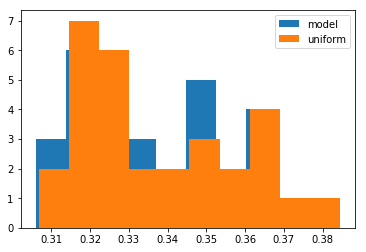

In [86]:
plt.hist(model_errs)
# plt.hist(random_errs)
plt.hist(uniform_errs)
# plt.legend(['model', 'random', 'uniform']);
plt.legend(['model', 'uniform'])

print('random: {} +- {}'.format(np.mean(random_errs), np.std(random_errs)))
print('uniform: {} +- {}'.format(np.mean(uniform_errs), np.std(uniform_errs)))
print('model: {} +- {}'.format(np.mean(model_errs), np.std(model_errs)));

# All together

In [16]:
with Timer():

    model_errs = []
    random_errs = []
    uniform_errs = []

    for run in range(runs):
        print('Run', run, '...')
        X_train, X_test, y_train, y_test = train_test_split(
            data['X'], data['y'], test_size=test_fraction)

        flatten_X_train = []
        flatten_y_train = []
        for i in range(len(X_train)):
            features = X_train[i]
            label = y_train[i]['influence_matrix']            
            flatten_X_train.append(np.hstack(
                [features['content_embedding_matrix'].flatten(),
                 np.array(features['reply_duration'].flatten())[0],
                 np.array(features['sentiment'].flatten())[0],
                 np.array(features['emotion_arousal'].flatten())[0],
                 np.array(features['emotion_dominance'].flatten())[0],
                 np.array(features['emotion_valence'].flatten())[0]]))
            flatten_y_train.append(np.array(label.flatten())[0])
        flatten_X_train = np.array(flatten_X_train)
        flatten_y_train = np.array(flatten_y_train)

        flatten_X_test = []
        flatten_y_test = []
        for i in range(len(X_test)):
            features = X_test[i]
            label = y_test[i]['influence_matrix']
            flatten_X_test.append(np.hstack(
                [features['content_embedding_matrix'].flatten(),
                 np.array(features['reply_duration'].flatten())[0],
                 np.array(features['sentiment'].flatten())[0],
                 np.array(features['emotion_arousal'].flatten())[0],
                 np.array(features['emotion_dominance'].flatten())[0],
                 np.array(features['emotion_valence'].flatten())[0]]))
            flatten_y_test.append(np.array(label.flatten())[0])
        flatten_X_test = np.array(flatten_X_test)
        flatten_y_test = np.array(flatten_y_test)

        model = Sequential([
            Dense(32, kernel_initializer='he_normal', activation='relu', input_shape=(3152,)),
            Dropout(0.5),
            Dense(64, kernel_initializer='he_normal', activation='relu'),
            Dropout(0.5),
            Dense(32, kernel_initializer='he_normal', activation='relu'),
            Dropout(0.5),
#             Dense(16, kernel_initializer='he_normal', activation='softmax')])
            Dense(16, kernel_initializer=my_init, activation='softmax')])
        model.compile(optimizer='adam',
                      loss='binary_crossentropy',
                      metrics=['accuracy'])
#         model = Sequential([
#             Dense(
#                 units=32,
#                 kernel_initializer='he_normal',
#                 activation='relu',
#                 input_shape=(3072,),
#                 kernel_regularizer=regularizers.l1(lambda1)),
#             Dropout(0.5),
#             Dense(
#                 units=64,
#                 kernel_initializer='he_normal',
#                 activation='relu',
#                 kernel_regularizer=regularizers.l1(lambda1)),
#             Dropout(0.5),
#             Dense(
#                 units=32,
#                 kernel_initializer='he_normal',
#                 activation='relu',
#                 kernel_regularizer=regularizers.l1(lambda1)),
#             Dropout(0.5),
#             Dense(
#                 units=16,
#                 kernel_initializer='he_normal',
#                 activation='softmax',
#                 kernel_regularizer=regularizers.l1(lambda1))
#         ])
#         model.compile(optimizer='adam',
#                       loss='binary_crossentropy',
#                       metrics=['accuracy'])

        model.fit(flatten_X_train, flatten_y_train, epochs=10, batch_size=32)

        predicted = model.predict(flatten_X_test)

        model_err = 0
        uniform_err = 0
        random_err = 0
        for i in range(len(y_test)):
            real_influence_matrix = y_test[i]['influence_matrix']

            # Random model prediction:
            pred_random_influence_matrix = np.matrix(utils.make_matrix_row_stochastic(
                np.random.rand(4, 4)))
            random_err += compute_matrix_err(
                real_influence_matrix, pred_random_influence_matrix)

            # Uniform prediction:
            pred_uniform_influence_matrix = np.matrix(np.ones((4, 4)) * 0.25)
            uniform_err += compute_matrix_err(
                real_influence_matrix, pred_uniform_influence_matrix)

            # Model's prediction:
            predicted_influence_matrix = predicted[i]
            predicted_influence_matrix = utils.make_matrix_row_stochastic(
                np.matrix(np.reshape(predicted_influence_matrix, (4, 4))))
            model_err += compute_matrix_err(
                real_influence_matrix, predicted_influence_matrix)

        model_err /= len(y_test)
        uniform_err /= len(y_test)
        random_err /= len(y_test)

        model_errs.append(model_err)
        random_errs.append(random_err)
        uniform_errs.append(uniform_err)

Run 0 ...
Train on 247 samples
Epoch 1/10
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
247/247 [==============================] - 1s 3ms/sample - loss: 0.7408 - accuracy: 0.0154
Epoch 2/10
247/247 [==============================] - 0s 139us/sample - loss: 0.7402 - accuracy: 0.0154
Epoch 3/10
247/247 [==============================] - 0s 104us/sample - loss: 0.7396 - accuracy: 0.0154
Epoch 4/10
247/247 [==============================] - 0s 99us/sample - loss: 0.7396 - accuracy: 0.0154
Epoch 5/10
247/247 [==============================] - 0s 101us/sample - loss: 0.7390 - accuracy: 0.0154
Epoch 6/10
247/247 [==============================] - 0s 87us/sample - loss: 0.7390 - accuracy: 0.0154
Epoch 7/10
247/247 [==============================] - 0s 86us/sample - loss: 0.7389 - accuracy: 0.0154
Epoch 8/10
247/247 [==============================] - 0s 84us/sample - loss: 0.7385 - accuracy: 0.0154
Epoch 9/10
247/247 [=============================

247/247 [==============================] - 0s 85us/sample - loss: 0.7396 - accuracy: 0.0149
Epoch 6/10
247/247 [==============================] - 0s 99us/sample - loss: 0.7391 - accuracy: 0.0149
Epoch 7/10
247/247 [==============================] - 0s 87us/sample - loss: 0.7389 - accuracy: 0.0149
Epoch 8/10
247/247 [==============================] - 0s 83us/sample - loss: 0.7384 - accuracy: 0.0149
Epoch 9/10
247/247 [==============================] - 0s 81us/sample - loss: 0.7384 - accuracy: 0.0149
Epoch 10/10
247/247 [==============================] - 0s 82us/sample - loss: 0.7382 - accuracy: 0.0149
Run 8 ...
Train on 247 samples
Epoch 1/10
247/247 [==============================] - 1s 2ms/sample - loss: 0.7409 - accuracy: 0.0142
Epoch 2/10
247/247 [==============================] - 0s 93us/sample - loss: 0.7400 - accuracy: 0.0142
Epoch 3/10
247/247 [==============================] - 0s 98us/sample - loss: 0.7397 - accuracy: 0.0142
Epoch 4/10
247/247 [==============================] -

247/247 [==============================] - 0s 91us/sample - loss: 0.7401 - accuracy: 0.0182
Epoch 3/10
247/247 [==============================] - 0s 74us/sample - loss: 0.7398 - accuracy: 0.0182
Epoch 4/10
247/247 [==============================] - 0s 83us/sample - loss: 0.7392 - accuracy: 0.0182
Epoch 5/10
247/247 [==============================] - 0s 78us/sample - loss: 0.7393 - accuracy: 0.0182
Epoch 6/10
247/247 [==============================] - 0s 80us/sample - loss: 0.7385 - accuracy: 0.0182
Epoch 7/10
247/247 [==============================] - 0s 82us/sample - loss: 0.7389 - accuracy: 0.0182
Epoch 8/10
247/247 [==============================] - 0s 78us/sample - loss: 0.7385 - accuracy: 0.0182
Epoch 9/10
247/247 [==============================] - 0s 85us/sample - loss: 0.7385 - accuracy: 0.0182
Epoch 10/10
247/247 [==============================] - 0s 74us/sample - loss: 0.7383 - accuracy: 0.0182
Run 16 ...
Train on 247 samples
Epoch 1/10
247/247 [==============================]

random: 0.629000514749951 +- 0.01566901726757875
uniform: 0.3434295278358921 +- 0.02040265156790686
model: 0.33717033132955276 +- 0.020186327022324663


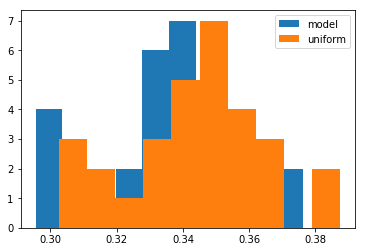

In [17]:
plt.hist(model_errs)
# plt.hist(random_errs)
plt.hist(uniform_errs)
# plt.legend(['model', 'random', 'uniform']);
plt.legend(['model', 'uniform'])

print('random: {} +- {}'.format(np.mean(random_errs), np.std(random_errs)))
print('uniform: {} +- {}'.format(np.mean(uniform_errs), np.std(uniform_errs)))
print('model: {} +- {}'.format(np.mean(model_errs), np.std(model_errs)));

# All with convolutional layers

In [113]:
import keras.backend as K

def my_metric(y_true, y_pred):
#     return K.mean(y_pred)
    return K.square(y_true - y_pred)

In [114]:
runs = 1

In [122]:
with Timer():
    
    input_dim = 3152

    model_errs = []
    random_errs = []
    uniform_errs = []

    for run in range(runs):
        print('Run', run, '...')
        X_train, X_test, y_train, y_test = train_test_split(
            data['X'], data['y'], test_size=test_fraction)

        flatten_X_train = []
        flatten_y_train = []
        for i in range(len(X_train)):
            features = X_train[i]
            label = y_train[i]['influence_matrix']            
            flatten_X_train.append(np.hstack(
                [features['content_embedding_matrix'].flatten(),
                 np.array(features['reply_duration'].flatten())[0],
                 np.array(features['sentiment'].flatten())[0],
                 np.array(features['emotion_arousal'].flatten())[0],
                 np.array(features['emotion_dominance'].flatten())[0],
                 np.array(features['emotion_valence'].flatten())[0]]))
            flatten_y_train.append(np.array(label.flatten())[0])
        flatten_X_train = np.array(flatten_X_train)
        flatten_y_train = np.array(flatten_y_train)

        flatten_X_test = []
        flatten_y_test = []
        for i in range(len(X_test)):
            features = X_test[i]
            label = y_test[i]['influence_matrix']
            flatten_X_test.append(np.hstack(
                [features['content_embedding_matrix'].flatten(),
                 np.array(features['reply_duration'].flatten())[0],
                 np.array(features['sentiment'].flatten())[0],
                 np.array(features['emotion_arousal'].flatten())[0],
                 np.array(features['emotion_dominance'].flatten())[0],
                 np.array(features['emotion_valence'].flatten())[0]]))
            flatten_y_test.append(np.array(label.flatten())[0])
        flatten_X_test = np.array(flatten_X_test)
        flatten_y_test = np.array(flatten_y_test)

        
    
        model = Sequential([
            Conv1D(
                32,
                2,
                kernel_initializer='he_normal',
                activation='relu',
                input_shape=(input_dim, 1),
                kernel_regularizer=regularizers.l1(lambda1),
                activity_regularizer=regularizers.l1(lambda1)),
            Conv1D(
                32,
                2,
                kernel_initializer='he_normal',
                activation='relu',
                kernel_regularizer=regularizers.l1(lambda1),
                activity_regularizer=regularizers.l1(lambda1)),
            MaxPooling1D(2),
            Conv1D(
                64,
                2,
                kernel_initializer='he_normal',
                activation='relu',
                kernel_regularizer=regularizers.l1(lambda1),
                activity_regularizer=regularizers.l1(lambda1)),
            Conv1D(
                64,
                2,
                kernel_initializer='he_normal',
                activation='relu',
                kernel_regularizer=regularizers.l1(lambda1),
                activity_regularizer=regularizers.l1(lambda1)),
            GlobalAveragePooling1D(),
            Dropout(0.5),
            Dense(
                units=16,
                kernel_initializer='he_normal',
                activation='softmax',
                kernel_regularizer=regularizers.l1(lambda1),
                activity_regularizer=regularizers.l1(lambda1))
        ])
        model.compile(optimizer='adam',
                      loss='binary_crossentropy',
                      metrics=['mae'])
        model.fit(
            np.reshape(flatten_X_train, (len(flatten_X_train), input_dim, 1)),
            flatten_y_train,
            epochs=200,
            batch_size=64)
        predicted = model.predict(np.reshape(flatten_X_test, (len(flatten_X_test), input_dim, 1)))

    

        model_err = 0
        uniform_err = 0
        random_err = 0
        for i in range(len(y_test)):
            real_influence_matrix = y_test[i]['influence_matrix']

            # Random model prediction:
            pred_random_influence_matrix = np.matrix(utils.make_matrix_row_stochastic(
                np.random.rand(4, 4)))
            random_err += compute_matrix_err(
                real_influence_matrix, pred_random_influence_matrix)

            # Uniform prediction:
            pred_uniform_influence_matrix = np.matrix(np.ones((4, 4)) * 0.25)
            uniform_err += compute_matrix_err(
                real_influence_matrix, pred_uniform_influence_matrix)

            # Model's prediction:
            predicted_influence_matrix = predicted[i]
            predicted_influence_matrix = utils.make_matrix_row_stochastic(
                np.matrix(np.reshape(predicted_influence_matrix, (4, 4))))
            model_err += compute_matrix_err(
                real_influence_matrix, predicted_influence_matrix)

        model_err /= len(y_test)
        uniform_err /= len(y_test)
        random_err /= len(y_test)

        model_errs.append(model_err)
        random_errs.append(random_err)
        uniform_errs.append(uniform_err)

Run 0 ...
Train on 247 samples
Epoch 1/200
247/247 [==============================] - 2s 6ms/sample - loss: 112222.9294 - mae: 0.1970
Epoch 2/200
247/247 [==============================] - 1s 3ms/sample - loss: 89950.1876 - mae: 0.1916
Epoch 3/200
247/247 [==============================] - 1s 3ms/sample - loss: 74589.1161 - mae: 0.1905
Epoch 4/200
247/247 [==============================] - 1s 3ms/sample - loss: 63980.0150 - mae: 0.1901
Epoch 5/200
247/247 [==============================] - 1s 3ms/sample - loss: 56416.1194 - mae: 0.1901
Epoch 6/200
247/247 [==============================] - 1s 3ms/sample - loss: 50792.8900 - mae: 0.1900
Epoch 7/200
247/247 [==============================] - 1s 3ms/sample - loss: 46449.3858 - mae: 0.1900
Epoch 8/200
247/247 [==============================] - 1s 3ms/sample - loss: 43016.6834 - mae: 0.1900
Epoch 9/200
247/247 [==============================] - 1s 3ms/sample - loss: 40250.2278 - mae: 0.1901
Epoch 10/200
247/247 [============================

247/247 [==============================] - 1s 3ms/sample - loss: 5538.6174 - mae: 0.1898
Epoch 160/200
247/247 [==============================] - 1s 3ms/sample - loss: 5481.0124 - mae: 0.1898
Epoch 161/200
247/247 [==============================] - 1s 3ms/sample - loss: 5423.9804 - mae: 0.1898
Epoch 162/200
247/247 [==============================] - 1s 3ms/sample - loss: 5367.6413 - mae: 0.1898
Epoch 163/200
247/247 [==============================] - 1s 3ms/sample - loss: 5311.8977 - mae: 0.1898
Epoch 164/200
247/247 [==============================] - 1s 3ms/sample - loss: 5256.8088 - mae: 0.1898
Epoch 165/200
247/247 [==============================] - 1s 3ms/sample - loss: 5202.4662 - mae: 0.1898
Epoch 166/200
247/247 [==============================] - 1s 3ms/sample - loss: 5148.6377 - mae: 0.1898
Epoch 167/200
247/247 [==============================] - 1s 3ms/sample - loss: 5095.5111 - mae: 0.1898
Epoch 168/200
247/247 [==============================] - 1s 3ms/sample - loss: 5042.990

In [131]:
np.sum(abs(real_influence_matrix - predicted_influence_matrix)) / 16

0.03664407338947057

In [132]:
np.sum(abs(real_influence_matrix - np.ones((4, 4)) * 0.25)) / 16

0.018749999999999996

random: 0.6446830015922933 +- 0.0
uniform: 0.33884002156124987 +- 0.0
model: 0.34167516294361333 +- 0.0


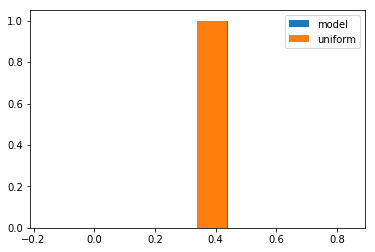

In [123]:
plt.hist(model_errs)
# plt.hist(random_errs)
plt.hist(uniform_errs)
# plt.legend(['model', 'random', 'uniform']);
plt.legend(['model', 'uniform'])

print('random: {} +- {}'.format(np.mean(random_errs), np.std(random_errs)))
print('uniform: {} +- {}'.format(np.mean(uniform_errs), np.std(uniform_errs)))
print('model: {} +- {}'.format(np.mean(model_errs), np.std(model_errs)));